In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sys
import os
src_path = os.path.abspath(os.path.join(os.getcwd(), '../src'))
sys.path.append(src_path)
from OCD import *

import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import wasserstein_distance as wd
import time
import ot

rng = np.random.seed(0)

size = 7;
cm = 0.393701; #inches
markers = ["o", "s", "<", ">", "d", "+"]


[KeOps] Warning : omp.h header is not in the path, disabling OpenMP. To fix this, you can set the environment
                  variable OMP_PATH to the location of the header before importing keopscore or pykeops,
                  e.g. using os.environ: import os; os.environ['OMP_PATH'] = '/path/to/omp/header'
[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


In [16]:
# import Neural OT
#!git clone https://github.com/mohsensadr/NeuralOptimalTransport.git

sys.path.append("NeuralOptimalTransport")

import matplotlib
%matplotlib inline

import torch
import torch.nn as nn
import gc

from src import distributions
import torch.nn.functional as F

from IPython.display import clear_output

from src.tools import unfreeze, freeze
from src import distributions

from src.plotters import plot_generated_2D, plot_generated_2D_new, plot_bar_and_stochastic_2D

from tqdm.notebook import tqdm as tqdm


DEVICE_IDS = [0]

T_ITERS = 10
f_LR, T_LR = 1e-4, 1e-4

ZD = 2
Z_STD = 0.1

#BATCH_SIZE = 1000 #64
Z_SIZE = 4

PLOT_INTERVAL = 200
MAX_STEPS = 201
SEED = 0x000000

DIM = 2

def weights_init_mlp(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')

H = 100

T = nn.Sequential(
    nn.Linear(DIM+ZD, H),
    nn.ReLU(True), 
    nn.Linear(H, H),
    nn.ReLU(True),
    nn.Linear(H, H),
    nn.ReLU(True),
    nn.Linear(H, DIM)
)#.cuda()

f = nn.Sequential(
    nn.Linear(DIM, H),
    nn.ReLU(True),
    nn.Linear(H, H),
    nn.ReLU(True),
    nn.Linear(H, H),
    nn.ReLU(True),
    nn.Linear(H, 1)
)#.cuda()

T.apply(weights_init_mlp); f.apply(weights_init_mlp)

if len(DEVICE_IDS) > 1:
    T = nn.DataParallel(T, device_ids=DEVICE_IDS)
    f = nn.DataParallel(f, device_ids=DEVICE_IDS)

print('T params:', np.sum([np.prod(p.shape) for p in T.parameters()]))
print('f params:', np.sum([np.prod(p.shape) for p in f.parameters()]))

T_opt = torch.optim.Adam(T.parameters(), lr=T_LR, weight_decay=1e-10)
f_opt = torch.optim.Adam(f.parameters(), lr=f_LR, weight_decay=1e-10)


def train_neural_OT(X0, Y0):
    BATCH_SIZE = X0.shape[0]
    
    for step in tqdm(range(MAX_STEPS)):
        # T optimization
        unfreeze(T); freeze(f)
        for t_iter in range(T_ITERS):
            T_opt.zero_grad()
            #X = X_sampler.sample(BATCH_SIZE).reshape(-1, 1, DIM).repeat(1, Z_SIZE, 1)
            X = X0.clone().reshape(-1, 1, DIM).repeat(1, Z_SIZE, 1)
            with torch.no_grad():
                Z = torch.randn(BATCH_SIZE, Z_SIZE, ZD, device='cpu') * Z_STD
                XZ = torch.cat([X, Z], dim=2)
            T_XZ = T(
                XZ.flatten(start_dim=0, end_dim=1)
            ).permute(1, 0).reshape(DIM, -1, Z_SIZE).permute(1, 2, 0)
    
            T_loss = F.mse_loss(X[:, 0], T_XZ.mean(dim=1)).mean() - f(
                T_XZ.flatten(start_dim=0, end_dim=1)).mean() - T_XZ.var(dim=1).mean() / Z_SIZE
            T_loss.backward(); T_opt.step()
        
        del T_loss, T_XZ, X, Z
        gc.collect(); #torch.cuda.empty_cache()
    
        # f optimization
        freeze(T); unfreeze(f)
    
        #X = X_sampler.sample(BATCH_SIZE)
        X = X0.clone()
        with torch.no_grad():
            Z = torch.randn(BATCH_SIZE, ZD, device='cpu') * Z_STD
            XZ = torch.cat([X, Z], dim=1)
            T_XZ = T(XZ)
        #Y = Y_sampler.sample(BATCH_SIZE)
        Y = Y0.clone()
    
        f_opt.zero_grad()
        f_loss = f(T_XZ).mean() - f(Y).mean()
        f_loss.backward(); f_opt.step()
    
        '''
        if step % PLOT_INTERVAL == 0:
            clear_output(wait=True)
            print("Step", step)
            print("Plotting")
            print("(DOT map appears only on the last step)")
    
            fig, axes = plot_generated_2D_new(X0, Y0, T, ZD, Z_STD)
            plt.show()
            
            #fig, axes = plot_generated_2D(X_sampler, Y_sampler, T, ZD, Z_STD)
            #plt.show()
            
            #fig, axes = plot_bar_and_stochastic_2D(
            #    X_sampler, Y_sampler, T, ZD, Z_STD,
            #    plot_discrete=True if step == MAX_STEPS-1 else False
            #)
            plt.show()
        '''
        del f_loss, Y, X, Z, XZ
        gc.collect(); #torch.cuda.empty_cache()
    return T_XZ

T params: 20902
f params: 20601


In [7]:
def find_optimal_map_sk_nd(X0, Y0, numItermax=100000, lambd=0.05):
  # X, Y with dim (Np, dim)
  n = X0.shape[0]
  a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples

  # loss matrix
  M = ot.dist(X0, Y0)

  #G0 = ot.emd(a, b, M, numItermax=numItermax)
  Gs = ot.sinkhorn(a, b, M, lambd, numItermax=numItermax)

  index_X = np.argmax(Gs, axis=1)
  #index_Y = np.argmax(G0, axis=0)

  return X0, Y0[index_X]

In [8]:
def find_optimal_map_nd(X0, Y0, numItermax=10000000):
  # X, Y with dim (Np, dim)
  n = X0.shape[0]
  a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples

  # loss matrix
  M = ot.dist(X0, Y0)

  G0 = ot.emd(a, b, M, numItermax=numItermax)

  index_X = np.argmax(G0, axis=1)
  #index_Y = np.argmax(G0, axis=0)

  return X0, Y0[index_X]

In [41]:
import numpy as np

def sampling_nd(Np=1000, seed=0, n=2):
    #X0 = np.random.uniform(-1.,1.,Np)
    #Y0 = np.random.normal(0.0, 1.0, Np)
    #Y0 = Y0/4
    
    np.random.seed(seed)
    
    #x = np.random.uniform(-1.,1.,(Np,n)) #np.random.normal(0,1,(Np,n))
    ##np.random.shuffle(x)

    ##y = np.concatenate( [ np.random.normal(-1,0.2,(int(Np/2),n)), np.random.normal(1,0.3,(Np-int(Np/2),n)) ] )
    ##np.random.shuffle(y)

    #y = np.random.normal(0.0, 1.0, (Np,n))
    #y = y/4
    
    x = np.random.normal(0.0, 1.0, (Np,n))
    y = np.random.normal(0.0, 1.0, (Np,n))
    
    return x, y


  0%|          | 0/201 [00:00<?, ?it/s]

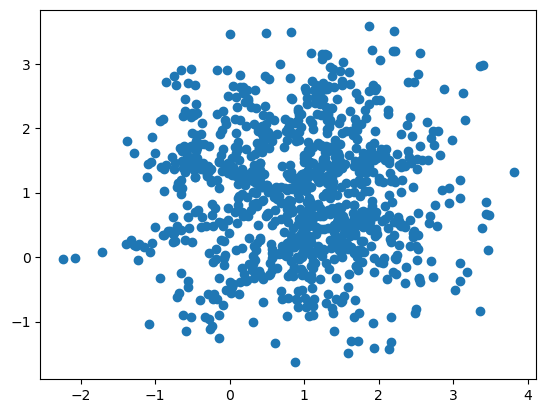

In [17]:
nd = 2
it = 0
Np = 1000
X0, Y0 = sampling_nd(Np, seed=it, n=nd)
#plt.scatter(Y0[:,0], Y0[:,1])

Xnot = train_neural_OT(torch.tensor(X0, dtype=torch.float), torch.tensor(Y0, dtype=torch.float))
plt.scatter(Xnot[:,0], Xnot[:,1])

In [23]:
print(np.sum(np.sum((X0-Xnot.numpy())**2,axis=1))**0.5/Np)

0.04442573958292276


In [111]:
import time
import tracemalloc
import numpy as np
import torch

# Initialize your parameters
eps = 0.1
nd = 2
Nps = [1000, 2000, 4000, 8000, 16000]
emd_time, ocd_time, not_time = [], [], []
ocd_err, not_err = [], []
emd_mem, ocd_mem, not_mem = [], [], []
it = 0

# OCD parameters
dt = 0.1
Nt = 200
tol = 1e-4

for Np in Nps:
    print(f"\nNp = {Np}")
    X0, Y0 = sampling_nd(Np, seed=it, n=nd)
    X00, Y00 = X0.copy(), Y0.copy()

    # ======== EMD ========
    tracemalloc.start()
    start = time.time()
    X_emd, Y_emd = find_optimal_map_nd(X0, Y0)
    end = time.time()
    _, peak_mem = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    emd_time.append(end - start)
    emd_mem.append(peak_mem / 1024**2)  # Convert to MB
    w2_emd = np.mean(np.sum((X_emd - Y_emd)**2, axis=1))
    print(f"EMD done | time={emd_time[-1]:.3f}s | mem={emd_mem[-1]:.2f} MB")

    # ======== OCD ========
    X0, Y0 = X00.copy(), Y00.copy()
    tracemalloc.start()
    start = time.time()
    eps0 = find_opt_eps2(X0, Y0, log_eps_range=[-3, 0], nepss=400, perc=0.9998)
    X_ocd, Y_ocd, dists, err_m2X, err_m2Y = ocd_map_RK4(X0, Y0, dt=dt, Nt=Nt, sigma=eps0, tol=tol)
    end = time.time()
    _, peak_mem = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    w2_ocd = np.mean(np.sum((Y_ocd - Y_ocd)**2, axis=1))
    ocd_err.append(abs(w2_ocd - w2_emd))
    ocd_time.append(end - start)
    ocd_mem.append(peak_mem / 1024**2)
    print(f"OCD done | error={ocd_err[-1]:.2e} | time={ocd_time[-1]:.3f}s | mem={ocd_mem[-1]:.2f} MB")

    # ======== Neural OT ========
    X0, Y0 = X00.copy(), Y00.copy()
    tracemalloc.start()
    start = time.time()
    Xnot = train_neural_OT(torch.tensor(X0, dtype=torch.float), torch.tensor(Y0, dtype=torch.float))
    end = time.time()
    _, peak_mem = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    not_time.append(end - start)
    w2_not = np.mean(np.sum((Xnot.numpy() - X00)**2, axis=1))
    not_err.append(abs(w2_not - w2_emd))
    not_mem.append(peak_mem / 1024**2)
    print(f"NOT done | error={not_err[-1]:.2e} | time={not_time[-1]:.3f}s | mem={not_mem[-1]:.2f} MB")



Np = 1000
EMD done | time=0.069s | mem=22.93 MB
OCD done | error=3.49e-02 | time=2.276s | mem=1.31 MB


  0%|          | 0/201 [00:00<?, ?it/s]

NOT done | error=5.14e-02 | time=75.447s | mem=0.06 MB

Np = 2000
EMD done | time=0.276s | mem=91.64 MB
OCD done | error=2.34e-02 | time=4.366s | mem=2.87 MB


  0%|          | 0/201 [00:00<?, ?it/s]

NOT done | error=7.83e-02 | time=87.872s | mem=0.07 MB

Np = 4000
EMD done | time=0.963s | mem=366.37 MB
OCD done | error=1.05e-02 | time=8.382s | mem=5.68 MB


  0%|          | 0/201 [00:00<?, ?it/s]

NOT done | error=4.51e-02 | time=122.049s | mem=0.07 MB

Np = 8000
EMD done | time=4.004s | mem=1465.17 MB
OCD done | error=7.01e-03 | time=16.605s | mem=11.25 MB


  0%|          | 0/201 [00:00<?, ?it/s]

NOT done | error=3.54e-02 | time=169.220s | mem=0.10 MB

Np = 16000
EMD done | time=22.324s | mem=5860.02 MB
OCD done | error=4.23e-03 | time=39.265s | mem=24.50 MB


  0%|          | 0/201 [00:00<?, ?it/s]

NOT done | error=2.16e-02 | time=270.748s | mem=0.07 MB


In [87]:
Nps =  [1000, 2000, 4000, 8000, 16000]

emd_time = [
    0.09337806701660156,
 0.30286383628845215,
 0.9646239280700684,
 3.946042060852051,
 20.612755060195923
]

ocd_time = [
1.315497875213623,
 2.6746299266815186,
 5.14580774307251,
 11.032299041748047,
 27.011616945266724
]

not_time = [
    75.93229722976685,
 92.97415113449097,
 121.84735798835754,
 155.49253511428833,
 261.68520975112915
]

not_err = [
0.0686159196372734,
 0.06118671488703746,
 0.033220636469981746,
 0.034480668568432266,
 0.024254391155875247
]

ocd_err = [
0.03487038048113885,
 0.0233529485037917,
 0.010463112685385596,
 0.007005067170861613,
 0.004231093584542478
]

#ocd_err

In [95]:
ocd_err

[0.03487038048113885,
 0.0233529485037917,
 0.010463112685385596,
 0.007005067170861613,
 0.004231093584542478]

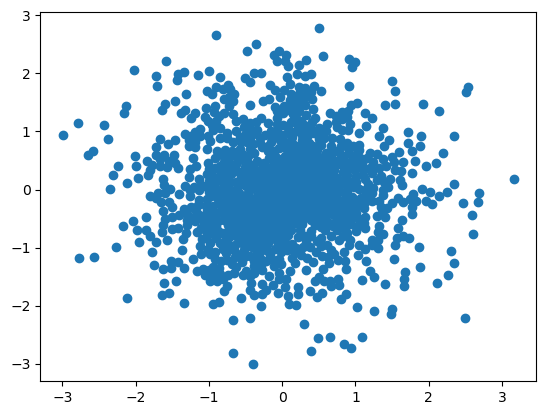

In [46]:
#plt.scatter(Xnot[:,0], Xnot[:,1])
plt.scatter(X_ocd[:,0], X_ocd[:,1])

In [88]:
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
import matplotlib.ticker
from matplotlib.ticker import ScalarFormatter, NullFormatter

# Define the model
def model(f, a, b):
    return a * f * np.log(f) + b

def fit_f_log_f(x, y, xx):
    # Initial guess for the parameters
    initial_guess = [1, 1]
    
    # Fit the curve
    popt, pcov = curve_fit(model, x, y, p0=initial_guess)
    
    # Extract the optimal parameters
    slope, intercept = popt
    
    # Compute the fitted y values
    fitted_y = model(xx, *popt)
    
    #xlogx = x*np.log10(x)
    #slope, intercept, r_value, p_value, std_err = linregress(xlogx, y)
    
    #fitted_y = slope*xlogx + intercept
    return fitted_y, slope, intercept

def fit_log(x, y, xx):
    log_x = np.log10(x)
    log_y = np.log10(y)

    slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)
    slope_str = f'{slope:.2f}'

    fitted_y = 10**(intercept + slope * np.log10(xx))
    return fitted_y, slope_str
xx = np.linspace(Nps[0],Nps[-1],100)

fitted_emd, slope_emd = fit_log(Nps, emd_time, xx)
#fitted_sk, slope_sk = fit_log(Nps, sk_time, xx)
fitted_ocd, slope_ocd = fit_log(Nps, ocd_time, xx)
#fitted_ocd, a_opt, b_opt = fit_f_log_f(np.array(Nps), np.array(ocd_time) , xx)

fitted_not, slope_not = fit_log(Nps, not_time, xx)

fig, ax = plt.subplots();

ax.plot(Nps, emd_time,label="EMD", marker="o", linestyle="", color="blue")
ax.plot(xx, fitted_emd, label=r'Fitted Function: $N_p^{'+slope_emd+'}$', color='blue', linestyle="--")

#ax.plot(Nps, sk_time,label=r"Sinkhorn, $\lambda=0.1$", marker="o", linestyle="", color="green")
#ax.plot(xx, fitted_sk, label=r'Fitted Function: $N_p^{'+slope_sk+'}$', color='green', linestyle="--")

ax.plot(Nps, ocd_time, label="OCD", marker="<", linestyle="", color="red")
#ax.plot(xx, fitted_ocd, label=r'Fitted Function: $N_p \log(N_p)$', color='red', linestyle="--")
ax.plot(xx, fitted_ocd, label=r'Fitted Function: $N_p^{'+slope_ocd+'}$', color='red', linestyle="--")

ax.plot(Nps, not_time, label="NOT", marker="s", linestyle="", color="green")
ax.plot(xx, fitted_not, label=rf'Fitted Function: $N_p^{{{slope_not}}}$', color='green', linestyle="--")

ax.set_ylabel("ex. time (s)")
ax.set_xlabel(r"$N_p$")
ax.set_yscale('log')
ax.set_xscale('log')
#for axis in [ax.xaxis]:
#    axis.set_major_formatter(ScalarFormatter())
#    axis.set_minor_formatter(NullFormatter())
#ax.set_xticks(Nps,Nps)
#ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax.legend()
fig.set_size_inches(size*cm*1.5, size*cm*1.5)
#fig.savefig(str(nd)+'d_time_norm0-1_norm1-1.pdf',format='pdf', bbox_inches="tight", dpi=300);

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 6 and the array at index 1 has size 1

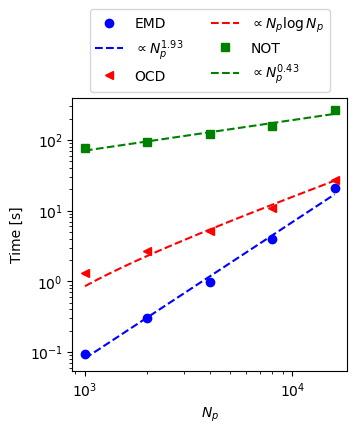

In [109]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import linregress
from matplotlib import pyplot as plt
import matplotlib.ticker
from matplotlib.ticker import ScalarFormatter, NullFormatter

# Define the model N log N
def model(f, a, b):
    return a * f * np.log(f) + b

def fit_f_log_f(x, y, xx):
    initial_guess = [1, 1]
    popt, pcov = curve_fit(model, x, y, p0=initial_guess)
    a_opt, b_opt = popt
    fitted_y = model(xx, *popt)
    return fitted_y, a_opt, b_opt

def fit_log(x, y, xx):
    log_x = np.log10(x)
    log_y = np.log10(y)
    slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)
    slope_str = f'{slope:.2f}'
    fitted_y = 10**(intercept + slope * np.log10(xx))
    return fitted_y, slope_str

# Fitting
xx = np.linspace(Nps[0], Nps[-1], 200)

fitted_emd, slope_emd = fit_log(Nps, emd_time, xx)
fitted_ocd, a_opt, b_opt = fit_f_log_f(np.array(Nps), np.array(ocd_time), xx)
fitted_not, slope_not = fit_log(Nps, not_time, xx)

# Plot
fig, ax = plt.subplots()

ax.plot(Nps, emd_time, label="EMD", marker="o", linestyle="", color="blue")
ax.plot(xx, fitted_emd, label=rf'$\propto N_p^{{{slope_emd}}}$', color='blue', linestyle="--")

ax.plot(Nps, ocd_time, label="OCD", marker="<", linestyle="", color="red")
ax.plot(xx, fitted_ocd, label=r'$\propto N_p \log N_p$', color='red', linestyle="--")

ax.plot(Nps, not_time, label="NOT", marker="s", linestyle="", color="green")
ax.plot(xx, fitted_not, label=rf'$\propto N_p^{{{slope_not}}}$', color='green', linestyle="--")

ax.set_ylabel("Time [s]")
ax.set_xlabel(r"$N_p$")
ax.set_yscale('log')
ax.set_xscale('log')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=2)

fig.set_size_inches(size*cm*1.5, size*cm*1.5)
fig.savefig('ex_Np_new.pdf',format='pdf', bbox_inches="tight", dpi=300)

In [ ]:
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
import matplotlib.ticker
from matplotlib.ticker import ScalarFormatter, NullFormatter

# Define the model
def model(f, a, b):
    return a * f * np.log(f) + b

def fit_f_log_f(x, y, xx):
    # Initial guess for the parameters
    initial_guess = [1, 1]
    
    # Fit the curve
    popt, pcov = curve_fit(model, x, y, p0=initial_guess)
    
    # Extract the optimal parameters
    slope, intercept = popt
    
    # Compute the fitted y values
    fitted_y = model(xx, *popt)
    
    #xlogx = x*np.log10(x)
    #slope, intercept, r_value, p_value, std_err = linregress(xlogx, y)
    
    #fitted_y = slope*xlogx + intercept
    return fitted_y, slope, intercept

def fit_log(x, y, xx):
    log_x = np.log10(x)
    log_y = np.log10(y)

    slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)
    slope_str = f'{slope:.2f}'

    fitted_y = 10**(intercept + slope * np.log10(xx))
    return fitted_y, slope_str
xx = np.linspace(Nps[0],Nps[-1],100)

fitted_emd, slope_emd = fit_log(Nps, emd_time, xx)
#fitted_sk, slope_sk = fit_log(Nps, sk_time, xx)
fitted_ocd, slope_ocd = fit_log(Nps, ocd_time, xx)
#fitted_ocd, a_opt, b_opt = fit_f_log_f(np.array(Nps), np.array(ocd_time) , xx)

fitted_not, slope_not = fit_log(Nps, not_time, xx)

fig, ax = plt.subplots();

ax.plot(Nps, emd_time,label="EMD", marker="o", linestyle="", color="blue")
ax.plot(xx, fitted_emd, label=r'Fitted Function: $N_p^{'+slope_emd+'}$', color='blue', linestyle="--")

#ax.plot(Nps, sk_time,label=r"Sinkhorn, $\lambda=0.1$", marker="o", linestyle="", color="green")
#ax.plot(xx, fitted_sk, label=r'Fitted Function: $N_p^{'+slope_sk+'}$', color='green', linestyle="--")

ax.plot(Nps, ocd_time, label="OCD", marker="<", linestyle="", color="red")
#ax.plot(xx, fitted_ocd, label=r'Fitted Function: $N_p \log(N_p)$', color='red', linestyle="--")
ax.plot(xx, fitted_ocd, label=r'Fitted Function: $N_p^{'+slope_ocd+'}$', color='red', linestyle="--")

ax.plot(Nps, not_time, label="NOT", marker="s", linestyle="", color="green")
ax.plot(xx, fitted_not, label=rf'Fitted Function: $N_p^{{{slope_not}}}$', color='green', linestyle="--")

ax.set_ylabel("ex. time (s)")
ax.set_xlabel(r"$N_p$")
ax.set_yscale('log')
ax.set_xscale('log')

ax.legend()
fig.set_size_inches(size*cm*1.5, size*cm*1.5)
#fig.savefig(str(nd)+'.pdf',format='pdf', bbox_inches="tight", dpi=300);

/var/folders/nz/1v01gjr111z1brxbfsl_vsgr0000gn/T/ipykernel_65008/1482074111.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


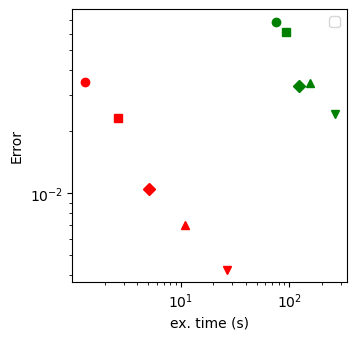

In [96]:
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h']

fig, ax = plt.subplots()

# Plot not_err/not_time with repeating markers
for i, (x, y) in enumerate(zip(not_time, not_err)):
    ax.plot(x, y, marker=markers[i % len(markers)], color='green', linestyle='')

# Plot ocd_err/ocd_time with the same marker pattern
for i, (x, y) in enumerate(zip(ocd_time, ocd_err)):
    ax.plot(x, y, marker=markers[i % len(markers)], color='red', linestyle='')


ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel("ex. time (s)")
ax.set_ylabel(r"Error")

ax.legend()
fig.set_size_inches(size*cm*1.5, size*cm*1.5)


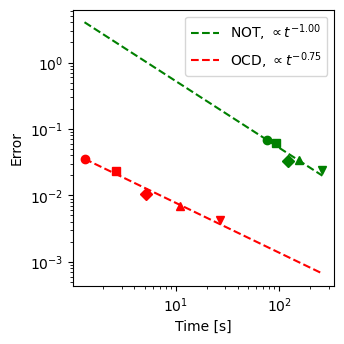

In [110]:
# Define power-law model: Error = a * Time^b
def power_law(t, a, b):
    return a * t**b

# Fit each dataset
params_not, _ = curve_fit(power_law, not_time, not_err)
params_ocd, _ = curve_fit(power_law, ocd_time, ocd_err)

# Smooth line for fit
not_time = np.array(not_time)
ocd_time = np.array(ocd_time)

t_fit = np.logspace(np.log10(min(not_time.min(), ocd_time.min())),
                    np.log10(max(not_time.max(), ocd_time.max())), 200)
not_fit = power_law(t_fit, *params_not)
ocd_fit = power_law(t_fit, *params_ocd)

# Markers to cycle through
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h']

# Plot data
fig, ax = plt.subplots()

# Non-OCD data
for i, (x, y) in enumerate(zip(not_time, not_err)):
    ax.plot(x, y, marker=markers[i % len(markers)], color='green', linestyle='')

# OCD data
for i, (x, y) in enumerate(zip(ocd_time, ocd_err)):
    ax.plot(x, y, marker=markers[i % len(markers)], color='red', linestyle='')

# Fitted curves
ax.plot(t_fit, not_fit, color='green', linestyle='--', 
        label=rf'NOT, $\propto t^{{{params_not[1]:.2f}}}$')
ax.plot(t_fit, ocd_fit, color='red', linestyle='--', 
        label=rf'OCD, $\propto t^{{{params_ocd[1]:.2f}}}$')

# Scales and labels
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Time [s]")
ax.set_ylabel("Error")
ax.legend()

# Optional figure sizing (adjust for your setup)
cm = 1 / 2.54
size = 6
fig.set_size_inches(size * cm * 1.5, size * cm * 1.5)

plt.tight_layout()
fig.savefig('err_time_new.pdf',format='pdf', bbox_inches="tight", dpi=300)

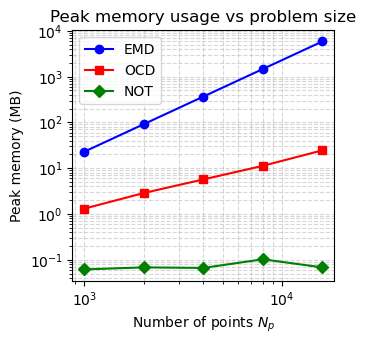

In [112]:
import matplotlib.pyplot as plt

# Convert lists to numpy arrays (optional, for consistency)
Nps = np.array(Nps)
emd_mem = np.array(emd_mem)
ocd_mem = np.array(ocd_mem)
not_mem = np.array(not_mem)

fig, ax = plt.subplots()

# Plot all three methods
ax.plot(Nps, emd_mem, 'o-', color='blue', label='EMD')
ax.plot(Nps, ocd_mem, 's-', color='red', label='OCD')
ax.plot(Nps, not_mem, 'D-', color='green', label='NOT')

# Scales and labels
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'Number of points $N_p$')
ax.set_ylabel('Peak memory (MB)')
ax.set_title('Peak memory usage vs problem size')

ax.legend()
ax.grid(True, which='both', linestyle='--', alpha=0.5)

# Optional size formatting (to match your earlier figure style)
cm = 1 / 2.54
size = 6
fig.set_size_inches(size * cm * 1.5, size * cm * 1.5)

plt.tight_layout()
plt.show()
